---
<span style="color:#000; font-family: 'Bebas Neue'; font-size: 2em;">Machine Learning III  Unsupervised and Network Analysis</span>

<span style="color:#f00; font-family: 'Bebas Neue'; font-size: 1.5em;">EXAMEN FINAL - PARTE I (3.5 puntos)</span>
<h4 style="color:darkblue"> Universidad Pontificia Comillas</h4>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e4/Comillas_Universidad_Pontificia_logo_%282018%29.jpg" alt="drawing" style="width:200px;"/>
<h5 style="color:black">  7 Abril 2024 - Madrid </h5>
<h5 style="color:gray"> Prof. María del Valle Varo García </h5>

---

`Yago Tobio souto`

***

**Problema 1 : Diabetes Database**

Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El **objetivo de este conjunto de datos es predecir de si un paciente tiene diabetes o no**, basado en ciertas medidas diagnósticas **incluidas en el conjunto de datos.** 
El conjunto de datos consta de varias variables médicas y una variable objetivo, `Outcome`.

El objetivo es **predecir el inicio de la diabetes basado en medidas diagnósticas realizando un análisis de Componentes Principales (PCA)** y verificando la eficiencia del PCA en la clasificación final. Generalmente, en el contexto médico, es mejor **reducir el número de categorías para la predicción debido a la sensibilidad de los datos.**


1. Realiza un **análisis de Componentes Principales** (PCA) y elige qué dimensión latente es la adecuada haciendo **un gráfica de rsme contra el k número de dimensiones**.

2. **¿Cuál es el efecto de estandarizar los datos frente a solo centrarlos?** ¿Qué impacto **tiene esto en el análisis PCA?** Comprueba **cómo se reparte la varianza en los loadings y cómo cambian los eigenvalues.**

3. Crea un modelo de aprendizaje automático (el proporcionado aquí, por ejemplo) y **compara su accuracy cuando se entrena sobre los datos de PCA frente al uso de los datos sin hacer PCA.**

4. Selecciona ahora **solo dos categorías a partir de la información proporcionada por el PCA y compara la eficiencia y precisión del modelo creando un biplot de las componentes principales.**


In [1]:
# Standard library imports
import itertools
import math
import os
import sys
import time
import warnings
from collections import defaultdict

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd
from scipy import sparse as sp, stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.sparse.linalg import svds
from scipy.special import softmax
from scipy.stats import multivariate_normal

# Text and natural language processing
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine Learning and Data Science libraries
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay

# Graph and plot libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cbook import boxplot_stats
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import plotly.express as px

# Deep Learning libraries
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset

# Transformer models
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Utility and other specific tools
from adjustText import adjust_text
from tabulate import tabulate
from tqdm.notebook import tqdm

# Recommender systems and specific utilities
import cornac
from cornac.data.text import BaseTokenizer
from cornac.data import GraphModality, ImageModality, TextModality, text as cornac_text
from cornac.datasets import amazon_clothing, filmtrust, movielens
from cornac.eval_methods import RatioSplit
from cornac.models import BPR, BaselineOnly, CTR, ItemKNN, MF, NMF, PMF, SVD, SoRec, UserKNN, VBPR, WMF
from cornac.utils import cache
#from cornac.datasets.python_splitters import python_random_split
#from cornac.models.cornac.cornac_utils import predict_ranking

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

#from recommenders.utils.timer import Timer
#from recommenders.datasets import movielens
#from recommenders.utils.notebook_utils import store_metadata
#from recommenders.models.recommenders.utils.constants import SEED
#from recommenders.datasets.python_splitters import python_random_split
#from recommenders.evaluation.python_evaluation import (
#    map,
#    ndcg_at_k,
#    precision_at_k,
#    recall_at_k,
#)

# Constants and configurations
SEED = 42
VERBOSE = False
pd.set_option("max_colwidth", 0)
%matplotlib inline

# Printing versions of libraries
print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"TensorFlow version: {tf.__version__}")

System version: 3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]
Cornac version: 2.1
TensorFlow version: 2.16.1


----

Pregunta 1: Realiza un **análisis de Componentes Principales** (PCA) y elige qué dimensión latente es la adecuada haciendo **un gráfica de rsme contra el k número de dimensiones**.

In [5]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.shape # * No hace falta hacer sample
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
df_pca = df.copy()
df_pca.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
X = df_pca.copy()
X = X.drop(columns=['Outcome'])
y = df_pca.Outcome

In [11]:
X_train, X_test, y_train, y_tests = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [12]:
# * - Paso III: Aplicamos el Standard Scaler con el objetivo de normalizar
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

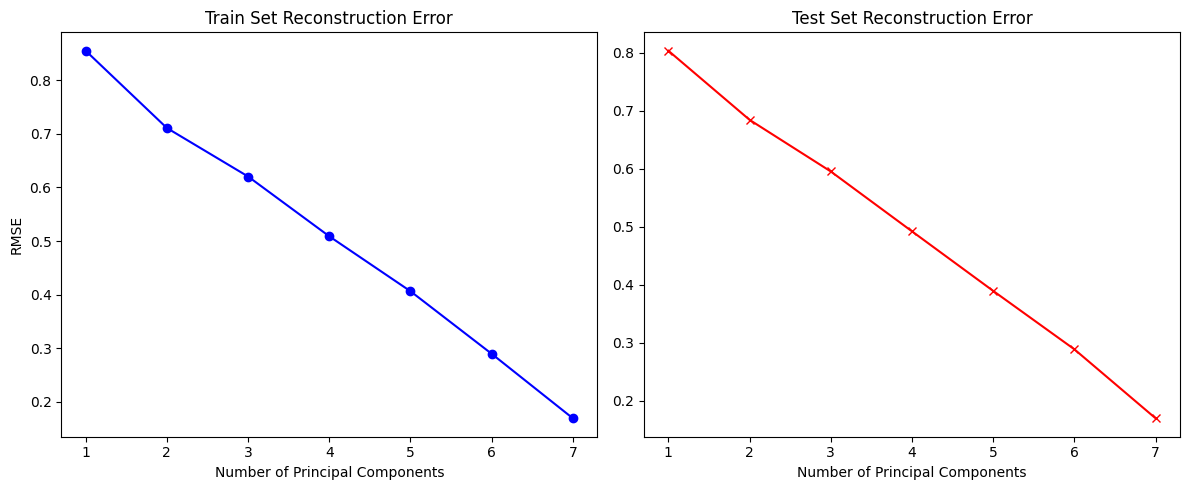

In [13]:
# Reconstruction error on MNIST vs number of latent dimensions used by PCA
# * This is dimension D
X_rank = np.linalg.matrix_rank(X_train)
max_components = min(X_train.shape[0], X_train.shape[1]) - 1
Ks = list(
    range(1, max_components + 1)
)  # Ajustando dinámicamente el rango basado en el tamaño del conjunto de datos
# * - Distinta manera de obtenerlo
#L_linspace = np.linspace(1, X_rank, 10, dtype=int) 


# ? - Vectors which are intended to store the RMSE values for train and test datasets.
RMSE_train = []
RMSE_test = []

# * For each L which we want to test out perform a PCA and it's corresponding reconstruction
# * Both for the train & test datasets - Then for that specific L, log what the RMS error is in order to plot it.
RMSE_train = []
RMSE_test = []

for index, K in enumerate(Ks):
    pca = PCA(n_components=K)

    Xtrain_transformed = pca.fit_transform(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train.append(root_mean_squared_error(X_train, Xtrain_proj))

    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test.append(root_mean_squared_error(X_test, Xtest_proj))

# * Plot train set reconstruction error vs. test set reconstruction error:
# Configurar la figura y los ejes para dos subplots: uno al lado del otro
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico para el conjunto de entrenamiento
axs[0].plot(Ks, RMSE_train, marker="o", color="blue")
axs[0].set_title("Train Set Reconstruction Error")
axs[0].set_xlabel("Number of Principal Components")
axs[0].set_ylabel("RMSE")

# Gráfico para el conjunto de prueba
axs[1].plot(Ks, RMSE_test, marker="x", color="red")
axs[1].set_title("Test Set Reconstruction Error")
axs[1].set_xlabel("Number of Principal Components")
# axs[1].set_ylabel("RMSE")  # Opcional, ya que comparten el mismo eje Y

plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama para dar un relleno especificado
plt.show()

> **Podemos observar que el RMSE decrece casi de manera lineal, lo cual indica que en todo nuestro dataset, tenemos variables que explican mucha información de manera independiente. Yo lo dejaría en 5 para poder encontrar un buen equilibrio entre la complejidad del modelo y el RMSE**

----

Pregunta 2: **¿Cuál es el efecto de estandarizar los datos frente a solo centrarlos?** ¿Qué impacto **tiene esto en el análisis PCA?** Comprueba **cómo se reparte la varianza en los loadings y cómo cambian los eigenvalues.**

> Centrar los valores hace que la media de cada variable sea igual a 0. En cambio estandarizarlos hace que PCA considere cada variable de la misma manera sin importar su rango de valores. Los pone todos en la misma escala -> Es decir, que los normaliza. Esto puede ser particularmente util en nuestro dataset por ejemplo al considerar **DiabetesPedigreeFunction** contra **Age** cuyo rango de valores es muy distinto, pero al aplicar PCA se debe de interpretar su información como iguales. Es esencial estandarizarlos, ya que si no a la variable edad, se le daría mucha más prioridad que PedrigreeFunction a la hora de generar los componentes principales

In [14]:
# ! - Como en el ultimo bucle hemos hecho PCA para todos los componentes, podemos sacar ahora el punto donde nuestro threshold se define: 
pca.components_.shape
eigenvalues = pca.explained_variance_
variance_explained = pca.explained_variance_ratio_
cumulative_variance_explained = pca.explained_variance_ratio_.cumsum()

**Como cambian los eigenvalues**

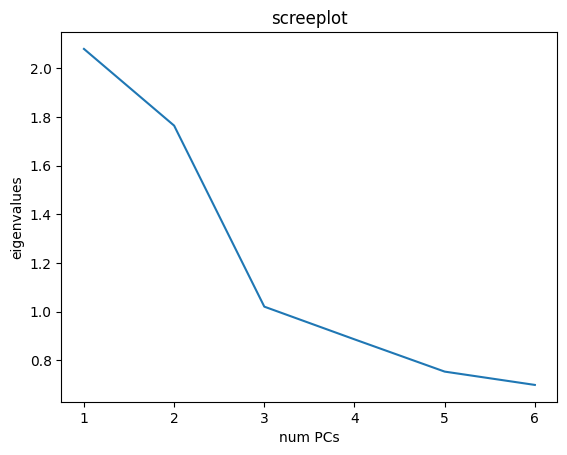

In [17]:
# * - Screeplot
fig, ax = plt.subplots()
xs = np.arange(1, len(eigenvalues))
ys = eigenvalues[0:len(eigenvalues)-1]
plt.title("screeplot")
plt.xlabel("num PCs")
plt.ylabel("eigenvalues")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.plot(xs, ys)
plt.show()

**Explicación de varianza en los autovectores:**

In [18]:
variance_explained

array([0.2595475 , 0.22020622, 0.12734819, 0.11057783, 0.09403196,
       0.08720167, 0.0510702 ])

In [47]:
print("Porcentaje sobre cuanto explica cada componente principal:")
variance_explained*100

Porcentaje sobre cuanto explica cada componente principal:


array([25.95474989, 22.02062194, 12.73481913, 11.05778317,  9.40319647,
        8.72016708,  5.10702049])

Text(0.5, 1.0, 'Number of Latent dimensions: 6')

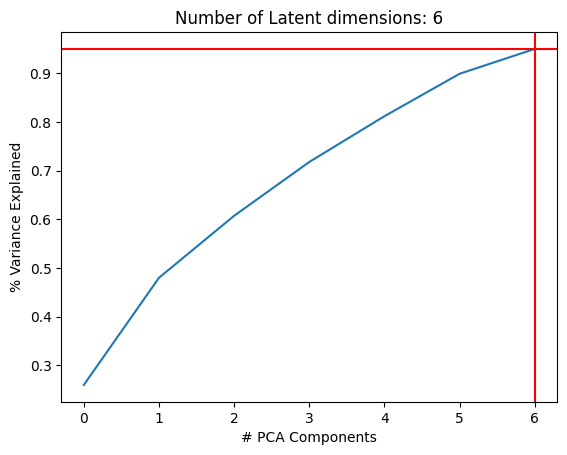

In [16]:
# * Cambia el threshold como veas relevante
threshold = 0.9
idx = np.where(cumulative_variance_explained >= threshold)[0][0]
exp_var = np.cumsum(pca.explained_variance_ratio_)

sns.lineplot(cumulative_variance_explained)
plt.axvline(idx, c="r")
plt.axhline(exp_var[idx], c="r")
plt.xlabel("# PCA Components")
plt.ylabel("% Variance Explained")
plt.title("Number of Latent dimensions: " + str(idx))

In [48]:
print(cumulative_variance_explained)

[0.2595475  0.47975372 0.60710191 0.71767974 0.81171171 0.89891338
 0.94998358]


Aunque el 6 alcanza un 89% de explicabilidad, vamos a optar por escoger n=5, ya que se prioriza que el modelo tenga un menor tamaño, y nos explica un 81% de los datos

----

**Pregunta 3:** 3. Crea un modelo de aprendizaje automático (el proporcionado aquí, por ejemplo) y **compara su accuracy cuando se entrena sobre los datos de PCA frente al uso de los datos sin hacer PCA.**

> Primer ejemplo con todos los datos sin haber hecho PCA - Datos normalizados

In [19]:
# EJEMPLO DE MODELO PARA UTILIZAR COMO CLASIFICADOR

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_tests, preds.argmax(axis=1))))

Accuracy: 0.75974


> Segundo ejemplo donde ahora decidimos aplicar PCA sobre nuestros datos

In [30]:
# Perform PCA in all datasets
subspace_dim = 6
pca = PCA(subspace_dim) # ! PCA con el numero optimo de lo que hallamos en la sección previa
XTR_pca = pca.fit_transform(X_train) # * X Training
XTS_pca = pca.fit_transform(X_test) # * X Test

In [31]:
clf.fit(XTR_pca, y_train)
preds = clf.predict_proba(XTS_pca)
print('Accuracy: {:.5f}'.format(accuracy_score(y_tests, preds.argmax(axis=1))))

Accuracy: 0.43506


> Podemos observar que cuando aplicamos PCA nuestro modelo de clasificación empeora mucho más a la hora de clasificar datos. **Sin PCA nuestro accuracy es del 75.9%, con el se reduce a un 43.5%**

##### **Versión Datos Sin Estandarizar - Solo Centrados**

In [35]:
X = df.copy()
X = X.drop(columns=['Outcome'])
y = df.Outcome

In [37]:
def center(x):
    y = x - x.mean()
    return y

X_centered = X.apply(center, axis=0)

In [39]:
X_train_c, X_test_c, y_train_c, y_tests_c = train_test_split(
    X_centered, y, test_size=0.2, random_state=0
)

In [40]:
# EJEMPLO DE MODELO PARA UTILIZAR COMO CLASIFICADOR

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train_c, y_train_c)
preds = clf.predict_proba(X_test_c)
print('Accuracy: {:.5f}'.format(accuracy_score(y_tests_c, preds.argmax(axis=1))))

Accuracy: 0.75974


**PCA sin estandarizar:**

In [45]:
# Perform PCA in all datasets
subspace_dim = 6
pca = PCA(subspace_dim) # ! PCA con el numero optimo de lo que hallamos en la sección previa
XTR_pca = pca.fit_transform(X_train_c) # * X Training
XTS_pca = pca.fit_transform(X_test_c) # * X Test

In [46]:
clf.fit(XTR_pca, y_train)
preds = clf.predict_proba(XTS_pca)
print('Accuracy: {:.5f}'.format(accuracy_score(y_tests_c, preds.argmax(axis=1))))

Accuracy: 0.75325


Podemos ver que en el caso donde no hemos **estandarizado** las variables, nos ha dado un mejor accuracy que el PCA con los datos normalizados, pero ligeramente peor accuracy que el resultado raw, donde no se han manipulado los datos. 

Por muy bueno que estoy parezca, es mala practica no estandarizar los datos, ya que estarán super sesgado hacia las variaciones de cada escala correspondiente

----

**Pregunta 4:**
Selecciona ahora **solo dos categorías a partir de la información proporcionada por el PCA y compara la eficiencia y precisión del modelo creando un biplot de las componentes principales.**

In [32]:
# Principal components correlation coefficients
loadings = pca.components_

# Number of features before PCA
n_features = pca.n_features_in_

# Feature names before PCA
feature_names = X.columns

# PC names
pc_list = [f"PC{i}" for i in list(range(1, n_features + 1))]

# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))

# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df["feature_names"] = feature_names
loadings_df = loadings_df.set_index("feature_names")
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
feature_names,,,,,,
Pregnancies,-0.183390,0.590229,0.024878,0.238652,0.292305,-0.207820
Glucose,-0.428306,0.104660,0.570241,-0.567484,-0.103358,-0.130300
BloodPressure,-0.366269,0.202445,-0.419367,-0.227718,-0.364635,0.654548
SkinThickness,-0.396060,-0.430674,-0.270714,0.211395,0.444613,0.087535
Insulin,-0.386665,-0.338535,0.140101,-0.176108,0.401944,0.064965
BMI,-0.439204,-0.088649,-0.374483,0.089105,-0.438789,-0.659816
DiabetesPedigreeFunction,-0.258089,-0.142583,0.513725,0.670099,-0.372598,0.241713
Age,-0.287899,0.520977,-0.035654,0.190990,0.283393,0.075729


/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_66988/503888605.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(xs[i], ys[i], s=200)
/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_66988/503888605.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xs[i],  # length of the arrow along x
/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_66988/503888605.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

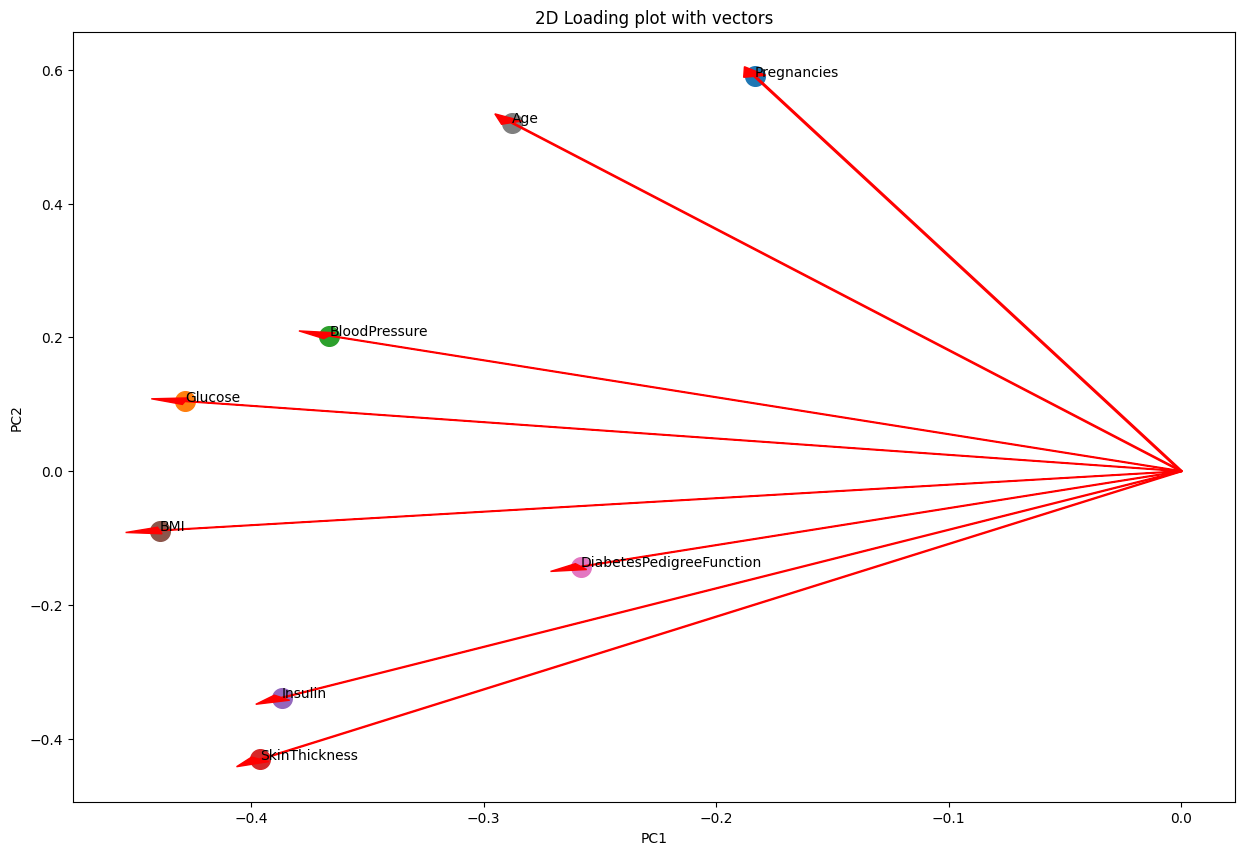

In [34]:
# Get the loadings of x and y axes
xs = loadings_df.iloc[:, 0]
ys = loadings_df.iloc[:, 1]

plt.figure(figsize=(15, 10))
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0,
        0,  # coordinates of arrow base
        xs[i],  # length of the arrow along x
        ys[i],  # length of the arrow along y
        color="r",
        head_width=0.01,
    )
    plt.text(xs[i], ys[i], varnames)

# Define the axes
ymin = np.min(ys.iloc[i])
ymax = np.max(ys.iloc[i])
# Define the axes
#xticks = np.linspace(0, 0.5, num=10)
#yticks = np.linspace(ymin, ymax, num=10)
#plt.xticks(xticks)
#plt.yticks(yticks)
plt.xlabel("PC1")
plt.ylabel("PC2")

# Show plot
plt.title("2D Loading plot with vectors")
plt.show()

> Podemos observar que las componentes que más información aportan entre sí, (las que son más perpendiculares) son **SkinThickness y Pregnancies.**
> En cambio, las variables mas correladas, parecen ser **BloodPressure y Glucose**, lo cual tiene sentido y refleja resultados de la vida real.